# Game app with Gradio: Image to caption to new Image

In [1]:
import os
import io
import IPython.display as IPdisplay
from PIL import Image
import base64
import requests, json
from dotenv import load_dotenv, find_dotenv
import gradio as gr

_ = load_dotenv(find_dotenv(filename="secrets.env", raise_error_if_not_found=True))

HF_API_TOKEN = os.environ["HF_API_TOKEN"]
HF_MODEL_TTI = "runwayml/stable-diffusion-v1-5" # Model for text to image inference
HF_MODEL_ITT = "Salesforce/blip-image-captioning-base" # Model for image to text inference
ITT_ENDPOINT = f"https://api-inference.huggingface.co/models/{HF_MODEL_ITT}"
TTI_ENDPOINT = f"https://api-inference.huggingface.co/models/{HF_MODEL_TTI}"
HEADERS = {"Authorization": f"Bearer {HF_API_TOKEN}"}
ROOT_DIR = os.environ["ROOT_DIR"]


## Helper functions

In [2]:
def API_call_ITT(prompt:str):
	response = requests.post(url=ITT_ENDPOINT, headers=HEADERS, json=prompt)
	return response.content

# API calls
def get_completion(inputs, parameters=None, ENDPOINT_URL=""):
    headers = {
      "Authorization": f"Bearer {HF_API_TOKEN}",
      "Content-Type": "application/json"
    }   
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.request("POST",
                                ENDPOINT_URL,
                                headers=headers,
                                data=json.dumps(data))
    return response.content

#Bringing the functions from lessons 3 and 4!
def image_to_base64_str(pil_image):
    byte_arr = io.BytesIO()
    pil_image.save(byte_arr, format='PNG')
    byte_arr = byte_arr.getvalue()
    return str(base64.b64encode(byte_arr).decode('utf-8'))

def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def captioner(image):
    base64_image = image_to_base64_str(image)
    result = get_completion(base64_image, None, ITT_ENDPOINT)
    return result[0]['generated_text']

def generate(prompt):
    output = get_completion(prompt, None, TTI_ENDPOINT)
    # result_image = base64_to_pil(output)
    result_image = Image.open(io.BytesIO(output))
    return result_image


### Image to text

In [3]:
def convertImageToByte(img):
	'''
	Convert a PIL Image to Byte
	'''
	ByteArray = io.BytesIO()
	img.save(ByteArray, format="PNG")
	ByteImg = ByteArray.getvalue()
	return ByteImg

def API_call_ITT(img):
	'''
	Send an Image as Byte to get caption generated
	'''
	ByteImg = convertImageToByte(img)
	response = requests.post(url=ITT_ENDPOINT, data=ByteImg)
	return response.content

# Helper function: convert bytes to text
def decodeBytes(bytes):
	output = json.loads(bytes.decode("utf-8"))
	return output

# extract content from it:
def captioner(img):
	bytes = API_call_ITT(img) # return bytes data 
	response = decodeBytes(bytes) # convert byte data. Here: list
	caption = response[0]["generated_text"] # extract the caption from the response
	return str(caption)

# Test image
img = Image.open(fp=f"{ROOT_DIR}/files/bored_dog.jpeg")

# Test the function
captioner(img)

'a dog with long hair laying on the floor'

### Text to Image

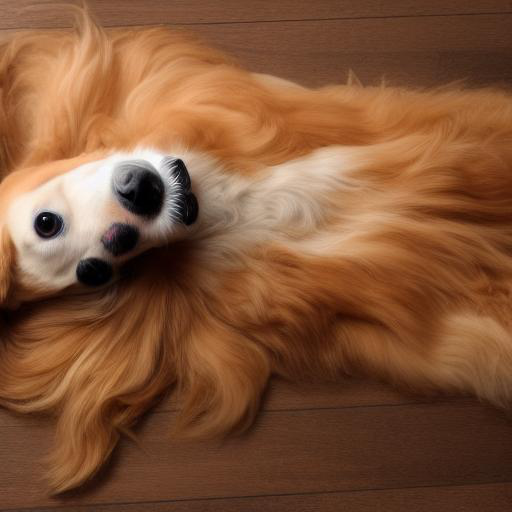

In [4]:
# API call to generate the image
def API_call_TTI(prompt:str):
	'''
	Generate an Image based on a text-prompt
	'''
	response = requests.post(url=TTI_ENDPOINT, headers=HEADERS, json=prompt)
	return response.content # return the image as a Byte-file 

# a test prompt
prompt = 'a dog with long hair laying on the floor'

# def the image generation function
def generate(prompt:str):
	byteImage = API_call_TTI(prompt=prompt)
	img = Image.open(io.BytesIO(byteImage)) # convert bytes to PIL image
	return img

# display the result
IPdisplay.display(generate(prompt=prompt))

## Gradio app: image to caption to image

In [8]:
# Helper function to chain the API calls
def captionAndGenerate(img):
	caption = captioner(img)
	genImg = generate(caption)
	return (caption, genImg)

# Build the app
with gr.Blocks(theme='Insuz/Mocha') as app:
	
	# Define all the elements of the app
	gr.Markdown("# Describe and generate")
	gr.Markdown(f"Given an image, will generate the caption for this image, and use them to generate a new image.\n\
			It is powered by {HF_MODEL_TTI} for the Image generation, and by {HF_MODEL_ITT} for caption generation.")
	uploadImage = gr.Image(label="Upload your image here to start the game", type="pil")
	button = gr.Button(value="Generate")
	caption = gr.Textbox(label="Caption")
	genImage = gr.Image(label="Generated image", type="pil")

	# define the actions
	button.click(
		fn=captionAndGenerate,
		inputs=uploadImage,
		outputs=[caption, genImage]
	)

gr.close_all()
app.launch()

Running on local URL:  http://127.0.0.1:7882

To create a public link, set `share=True` in `launch()`.
